Course Human-Centered Data Science ([HCDS](https://www.mi.fu-berlin.de/en/inf/groups/hcc/teaching/winter_term_2020_21/course_human_centered_data_science.html)) - Winter Term 2020/21 - [HCC](https://www.mi.fu-berlin.de/en/inf/groups/hcc/index.html) | [Freie Universität Berlin](https://www.fu-berlin.de/)
***
# A2 - Reproducibility Workflow - Monthly Wikipedia traffic

### What is the purpose of this notebook?
The goal of this project is to construct, analyze, and publish a data set of the monthly traffic on Wikipedia.

## Step 1️⃣: Data acquisition
In order to measure Wikipedia traffic from January 2008 until October 2020, you will need to collect data from two different APIs:

1. The **Legacy Pagecounts API** ([documentation](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Legacy_Pagecounts), [endpoint](https://wikimedia.org/api/rest_v1/#!/Pagecounts_data_(legacy)/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end)) provides access to desktop and mobile traffic data from December 2007 through July 2016.
1. The **Pageviews API** ([documentation](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews), [endpoint](https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end)) provides access to desktop, mobile web, and mobile app traffic data from July 2015 through last month.

For each API, we need to collect data for all months where data is available and then save the raw results into five (3+2) separate `JSON`files (one file per API query type) before continuing to step 2.

---
We begin by retrieving the data from the Wikimedia REST API's using the json and request library.
Optionally, customize the REST API parameters such as `start` and `end` to fetch smaller timeframes. For now we use the maximum timespan the API's provide us.

In [ ]:
# Source: https://public.paws.wmcloud.org/User:Jtmorgan/data512_a1_example.ipynb?format=raw

import json
import requests
import copy

endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

# SAMPLE parameters for getting aggregated legacy view data 
# see: https://wikimedia.org/api/rest_v1/#!/Legacy_data/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end
rest_params_legacy_desktop = {
    "project" : "en.wikipedia.org",
    "access-site" : "desktop-site",
    "granularity" : "monthly",
    "start" : "2008010100",
    "end" : "2016073123"
}

# SAMPLE parameters for getting aggregated current standard pageview data
# see: https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end
rest_params_pageviews_desktop = {
    "project" : "en.wikipedia.org",
    "access" : "desktop",
    "agent" : "user",
    "granularity" : "monthly",
    "start" : "2015070100",
    "end" : '2020110100'
}

Next we create the additional REST API parameters to get also the mobile traffic. 

In [ ]:
rest_params_legacy_mobile = copy.deepcopy(rest_params_legacy_desktop)
rest_params_legacy_mobile["access-site"] = "mobile-site"

rest_params_pageviews_mobile_web = copy.deepcopy(rest_params_pageviews_desktop)
rest_params_pageviews_mobile_app = copy.deepcopy(rest_params_pageviews_desktop)
rest_params_pageviews_mobile_web["access"] = "mobile-web"
rest_params_pageviews_mobile_app["access"] = "mobile-app"

Your ToDo here ist to exchange the `User-Agent` and `From` headers with your own information

In [ ]:
headers = {
    'User-Agent': 'https://github.com/Arne117',
    'From': 'arner92@zedat.fu-berlin.de'
}

Now we create a function that requests the data from the API to a given `endpoint` and `parameters`.

In [7]:
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

In the next step we retrieve and save the `desktop` and `mobile traffic` data from the legacy pagecounts REST API in two sperate `.json` files. The naming convention for the source data files is: `apiname_accesstype_firstmonth-lastmonth.json`

In [6]:
legacy_monthly_desktop = api_call(endpoint_legacy, rest_params_legacy_desktop)
legacy_monthly_mobile = api_call(endpoint_legacy, rest_params_legacy_mobile)

with open('../data_raw/pagecounts_desktop-site_200801-201607.json', 'w') as json_file:
    json.dump(legacy_monthly_desktop, json_file)

with open('../data_raw/pagecounts_mobile-site_200801-201607.json', 'w') as json_file:
    json.dump(legacy_monthly_mobile, json_file)


Now we retrieve and save the `desktop`, `mobile-web` and `mobile-app` traffic data from the pageviews REST API in three sperate `.json` files.

In [9]:
pageviews_monthly_desktop = api_call(endpoint_pageviews, rest_params_pageviews_desktop)
pageviews_monthly_mobile_web = api_call(endpoint_pageviews, rest_params_pageviews_mobile_web)
pageviews_monthly_mobile_app = api_call(endpoint_pageviews, rest_params_pageviews_mobile_app)

with open('../data_raw/pageviews_desktop_201507-202010.json', 'w') as json_file:
    json.dump(pageviews_monthly_desktop, json_file)

with open('../data_raw/pageviews_mobile-web_201507-202010.json', 'w') as json_file:
    json.dump(pageviews_monthly_mobile_web, json_file)
    
with open('../data_raw/pageviews_mobile-app_201507-202010.json', 'w') as json_file:
    json.dump(pageviews_monthly_mobile_app, json_file)

The `JSON`-formatted source data file now contains the complete and un-edited output of your API queries.
The naming convention for the source data files follows: `apiname_accesstype_firstmonth-lastmonth.json`. 
For example: `pagecounts_desktop-site_200801-202010.json`

### Important notes❗
1. As much as possible, we're interested in *organic* (user) traffic, as opposed to traffic by web crawlers or spiders. The Pageview API (but not the Pagecount API) allows you to filter by `agent=user`. You should do that.
1. There is about one year of overlapping traffic data between the two APIs. You need to gather, and later graph, data from both APIs for this period of time.

## Step 2: Data processing

We will perform a series of processing steps on these data files in order to prepare them for analysis. These steps must be followed exactly in order to prepare the data for analysis. At the end of this step, you will have a single `CSV`-formatted data file `en-wikipedia_traffic_200712-202010.csv` that can be used in your analysis (step 3) with no significant additional processing.

* For data collected from the Pageviews API, we combine the monthly values for `mobile-app` and `mobile-web` to create a total mobile traffic count for each month.
* For all data, we separate the value of `timestamp` into four-digit year (`YYYY`) and two-digit month (`MM`) and discard values for day and hour (`DDHH`).

Combine all data into a single CSV file with the following headers:

| year | month |pagecount_all_views|pagecount_desktop_views|pagecount_mobile_views|pageview_all_views|pageview_desktop_views|pageview_mobile_views|
|------| ------|-------------------|-----------------------|----------------------|------------------|----------------------|---------------------|
| YYYY | MM    |num_views          |num_views              |num_views             |num_views         |num_views             |num_views            | 

---
For the data processing part we are using the Pandas library. We then convert the data from json into a Pandas data frame. Here we are using the already used vairables from data acquisition part but we could also load the file directly from the `data_raw` folder. Afterwards we define the "hull" for the final dataset that we are going to export to a `.csv` file.

In [ ]:
import pandas as pd

legacy_monthly_desktop_df = pd.DataFrame(legacy_monthly_desktop['items'])
legacy_monthly_mobile_df = pd.DataFrame(legacy_monthly_mobile['items'])
pageviews_monthly_desktop_df = pd.DataFrame(pageviews_monthly_desktop['items'])
pageviews_monthly_mobile_web_df = pd.DataFrame(pageviews_monthly_mobile_web['items'])
pageviews_monthly_mobile_app_df = pd.DataFrame(pageviews_monthly_mobile_app['items'])

final_dataset = pd.DataFrame({
  'timestamp': [] # will be removed later
  }
)

Here we merge the data frames that don't need to be transformed into the final dataset by just renaming the columns:

In [ ]:
final_dataset = pd.merge(final_dataset, legacy_monthly_desktop_df[['timestamp', 'count']], on='timestamp', how='outer').rename(columns={"count": "pagecount_desktop_views"})
final_dataset = pd.merge(final_dataset, legacy_monthly_mobile_df[['timestamp', 'count']], on='timestamp', how='outer').rename(columns={"count": "pagecount_mobile_views"})
final_dataset = pd.merge(final_dataset, pageviews_monthly_desktop_df[['timestamp', 'views']], on='timestamp', how='outer').rename(columns={"views": "pageview_desktop_views"})

We then combine combine the monthly values for mobile-app and mobile-web to create a total mobile traffic count for each month.

In [ ]:
pageviews_mobile_df = pd.merge(pageviews_monthly_mobile_web_df[['timestamp', 'views']], pageviews_monthly_mobile_app_df[['timestamp', 'views']], on='timestamp') # .set_index('timestamp').sum(axis=1)
pageviews_mobile_df["views"] = pageviews_mobile_df.loc[:, ["views_x", "views_y"]].sum(axis=1)
pageviews_mobile_df = pageviews_mobile_df.drop(columns=['views_x', 'views_y'])
final_dataset = pd.merge(final_dataset, pageviews_mobile_df, on='timestamp', how='outer').rename(columns={"views": "pageview_mobile_views"})

We proceed to calculate the total amount of pageviews and pagecounts:

In [ ]:
final_dataset['pagecount_all_views'] = final_dataset.iloc[:, 1:3].sum(axis=1)
final_dataset['pageview_all_views'] = final_dataset.iloc[:, 3:5].sum(axis=1)

Now lets change the timestep format to year (YYYY) and month (MM) and remove the `timestamp` column:

In [ ]:
timestamp_orig = final_dataset['timestamp'].str.slice(stop=6)
final_dataset['year'] = timestamp_orig.str.slice(stop=4)
final_dataset['month'] = timestamp_orig.str.slice(start=-2)
final_dataset = final_dataset.drop(columns=['timestamp'])

Lets rearrange the columns to the wanted sequence:

In [ ]:
final_dataset = final_dataset[['year', 'month', 'pagecount_all_views', 'pagecount_desktop_views', 'pagecount_mobile_views', 'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views']]

Finally we export the dataset to a `.csv` file to the `data_clean` folder:

In [155]:
final_dataset.to_csv('../data_clean/en-wikipedia_traffic_200801-202010.csv', index=False)

## Step 3: Analysis

For this assignment, the "analysis" will be fairly straightforward: you will visualize the dataset you have created as a **time series graph**. Your visualization will track three traffic metrics: mobile traffic, desktop traffic, and all traffic (mobile + desktop). In order to complete the analysis correctly and receive full credit, your graph will need to be the right scale to view the data; all units, axes, and values should be clearly labeled; and the graph should possess a legend and a title. You must also generate a .png or .jpeg formatted image of your final graph.
Please graph the data in your notebook, rather than using an external application!

First we load our data frame from the `.csv` file again:

In [174]:
final_df = pd.read_csv('../data_clean/en-wikipedia_traffic_200801-202010.csv')

For plotting we use the matplotlib library.
To prepare the plot we need to set the index of our final pandas data frame to a pandas datetime object to work with the `year` and `month` structure in the `.csv` file.
Data from the legacy API is shown through a `dashed` line.
Data from the pageview API is shown as a filled line.

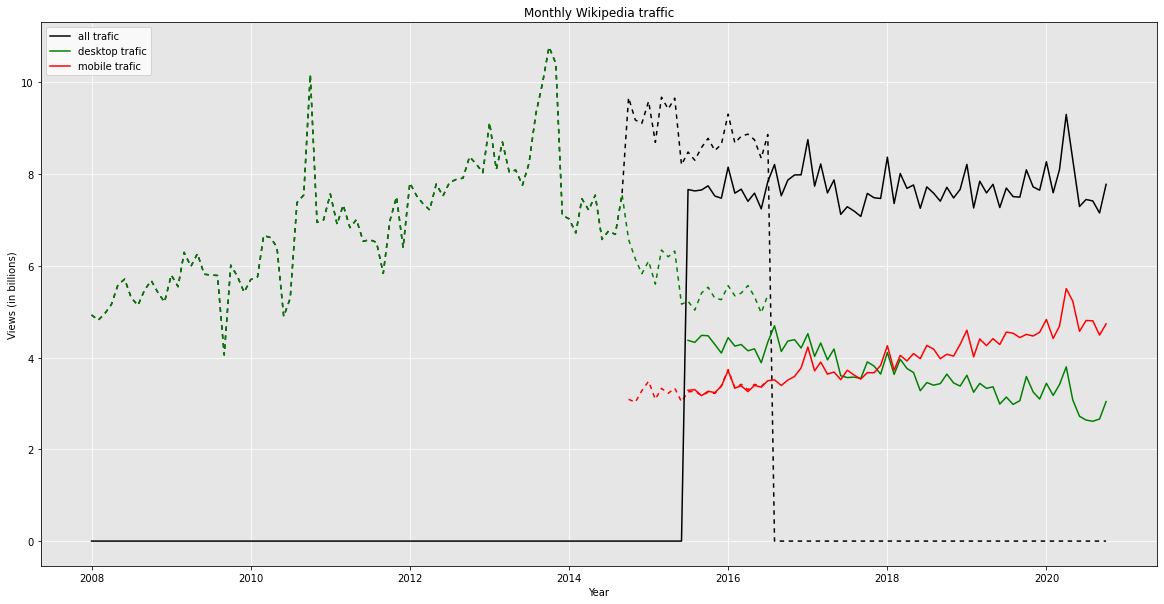

In [175]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# https://stackoverflow.com/questions/53259415/month-year-with-value-plot-pandas-and-matplotlib
final_df.set_index(pd.to_datetime({
    'day': 1,
    'month': final_df.pop('month'),
    'year': final_df.pop('year')
}), inplace=True)

fig, ax = plt.subplots(figsize=(20,10))
# plt.figure(figsize=(20,10))

dashes=(3, 3)
linestyle='dashed'

ax.plot(final_df.index.values, final_df['pagecount_all_views'], 'black', linestyle=linestyle, dashes=dashes)
ax.plot(final_df.index.values, final_df['pagecount_desktop_views'], 'g', linestyle=linestyle, dashes=dashes)
ax.plot(final_df.index.values, final_df['pagecount_mobile_views'], 'r', linestyle=linestyle, dashes=dashes)
ax.plot(final_df.index.values, final_df['pageview_all_views'], 'black', label='all trafic')
ax.plot(final_df.index.values, final_df['pageview_desktop_views'], 'g', label='desktop trafic')
ax.plot(final_df.index.values, final_df['pageview_mobile_views'], 'r', label='mobile trafic')

ax.set_xlabel('Year')
ax.set_ylabel('Views (in billions)')
# ax.autoscale(enable=True, axis='both', tight=None)
ax.set_facecolor('#e6e6e6')
ax.grid(color="white")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: int(x/1000000000)))
ax.set_title('Monthly Wikipedia traffic')

ax.legend(loc='upper left')
fig.savefig('../results/monthly_wikipedia_traffic.png', bbox_inches='tight')

***

#### Credits

This exercise is slighty adapted from the course [Human Centered Data Science (Fall 2019)](https://wiki.communitydata.science/Human_Centered_Data_Science_(Fall_2019)) of [Univeristy of Washington](https://www.washington.edu/datasciencemasters/) by [Jonathan T. Morgan](https://wiki.communitydata.science/User:Jtmorgan).

Same as the original inventors, we release the notebooks under the [Creative Commons Attribution license (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/).